In [1]:
#Import pandas
import pandas as pd
import numpy as np
import nltk
from nltk import sent_tokenize
from textblob import TextBlob
from textblob import Word
from nltk import ngrams
#import plots
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Phrases
from gensim.models.phrases import Phraser
import gensim.models.keyedvectors as word2vec

%matplotlib inline

In [2]:
s0 = "very good looking. Average product by Honor. For 2000 bucks, it is really a good option to buy. Easy to use and looks durable"
s1 = "very good looking. Among the best premium wireless headphones. Must buy-product."
s2 = "very good looking. No refund received for microwave oven, delivery guys was quite ignorant to our complaints and queries."
s3 = "Very bad experience with the router. Cables are completely damaged."
s4 = "Purchased the product based on Mi Brand. Product proves to be a disappointment. Worst Led TV in the market.Pathetic after sales service."
s5 = "very good looking. This earbuds are awesome. Completely value for money."

In [3]:
rev_list = [s0,s1,s2,s3,s4,s5]
new_list = []
for i in rev_list:
    new_list.append(i)
sample = pd.DataFrame(new_list, columns = ['reviews'])
sample['ratings'] = [1,1,0,0,0,1]

In [4]:
#documents = ["the mayor of new york was there", "machine learning can be useful sometimes"]

def get_bigrams(col):
    sentence_stream = [doc.split(" ") for doc in col]
    bigram = Phrases(sentence_stream, min_count=1, delimiter=b' ')
    for sent in sentence_stream:
        bigrams = [b for b in bigram[sent] if b.count(' ') == 1]
    return bigrams
    
def get_trigrams(col):
    sentence_stream = [doc.split(" ") for doc in col]
    trigram = Phrases(bigram[sentence_stream], min_count=1, delimiter=b' ')
    for sent in sentence_stream:
        trigrams = [t for t in trigram[bigram[sent]] if t.count(' ') == 2]
    return trigrams
get_trigrams(sample['reviews'])

In [5]:
#Usage of gensim in bigram and trigrams

from gensim.models import Phrases
from gensim.models.phrases import Phraser
import gensim.models.keyedvectors as word2vec

def make_bigrams(col):
    sent = [doc.split(" ") for doc in col]
    bigram = Phrases(sent, min_count=1, threshold = 1)
    corpus = [topic for topic in bigram[sent]]
    bigram_set = set(word for item in corpus for word in item if '_' in word)
    return bigram_set

def make_trigrams(col):
    sent = [doc.split(" ") for doc in col]
    trigram = Phrases(bigram[sent], min_count=1, threshold = 1)
    corpus = [topic for topic in trigram[sent]]
    trigram_set = set(word for item in corpus for word in item if word.count("_") > 1)
    return corpus

make_bigrams(sample['reviews'])


{'very_good'}

In [6]:
def detect_polarity(col):
    return TextBlob(col).sentiment.polarity
def detect_subjectivity(col):
    return TextBlob(col).sentiment.subjectivity
def get_lemma(col):
    lemma_list = []
    text = TextBlob(col).words
    for item in text:
        lemma = Word(item).lemmatize()
        lemma_list.append(lemma)
    return lemma_list
def detect_sentence_polarity(col):
    scores = []
    for sentences in TextBlob(col).sentences:
        score = np.round(sentences.sentiment.polarity,2)
        scores.append(score)
    return scores
def sentence_count(col_name, sign = 'total'):
    count_list = []
    for reviews in col_name:
        total_count = len(sent_tokenize(reviews))
        if sign == 'total':
            count_list.append(total_count)
        else:
            count = 0
            for sentence in sent_tokenize(reviews):
                polarity = TextBlob(sentence).sentiment.polarity
                if sign == 'positive' and polarity >= 0.2 :
                    count += 1
                elif sign == 'neutral' and polarity in (0,0.2):
                    count += 1
                elif sign == 'negative' and polarity <0 :
                    count += 1
            count_list.append(count)
    return count_list 

def calc_percentage(col_name, sign = 'positive'):
    count = sentence_count(col_name, sign)
    total_count = sentence_count(col_name, 'total')
    percent_list = [np.round((i / j)*100) for i, j in zip(count, total_count)]
    return percent_list

def negative_boolean(col):
    value = 0
    value_list = []
    for sentence in col:
        polarity = detect_polarity(sentence)
        if polarity < 0:
            value = 1
        else: 
            value = 0
        value_list.append(value)
    return value_list

filter_method = lambda x:'Highly Positive' if x >= 0.5 else 'Fairly Positive' if (x > 0 and x < 0.5) else 'Highly Negative' if x <= -0.5 else 'Fairly Negative' if (x > -0.5 and x < 0) else 'Neutral'

In [7]:
sample['polarity'] = round(sample.reviews.apply(detect_polarity),1)
sample['subjectivity'] = round(sample.reviews.apply(detect_subjectivity),1)
sample['sentiment'] = sample['polarity'].apply(filter_method)
sample['sentence_sentiment'] = sample.reviews.apply(detect_sentence_polarity)
sample['lemma'] = sample.reviews.apply(get_lemma)
sample['#positive_sentences']= sentence_count(sample['reviews'], 'positive')
sample['#neutral_sentences']= sentence_count(sample['reviews'], 'neutral')
sample['#negative_sentences'] = sentence_count(sample['reviews'], 'negative')
sample['% positive_sentences'] = calc_percentage(sample['reviews'], 'positive')
sample['% negative_sentences'] = calc_percentage(sample['reviews'], 'negative')
sample['% neutral_sentences'] = calc_percentage(sample['reviews'], 'neutral')
sample['negation_or_not'] = negative_boolean(sample['reviews'])
sample.head(6)

,reviews,ratings,polarity,subjectivity,sentiment,sentence_sentiment,lemma,#positive_sentences,#neutral_sentences,#negative_sentences,% positive_sentences,% negative_sentences,% neutral_sentences,negation_or_not
0,very good looking. Average product by Honor. F...,1,0.5,0.7,Highly Positive,"[0.91, -0.15, 0.7, 0.43]","[very, good, looking, Average, product, by, Ho...",3,0,1,75.0,25.0,0.0,0
1,very good looking. Among the best premium wire...,1,1.0,0.5,Highly Positive,"[0.91, 1.0, 0.0]","[very, good, looking, Among, the, best, premiu...",2,1,0,67.0,0.0,33.0,0
2,very good looking. No refund received for micr...,0,0.9,0.8,Highly Positive,"[0.91, 0.0]","[very, good, looking, No, refund, received, fo...",1,1,0,50.0,0.0,50.0,0
3,Very bad experience with the router. Cables ar...,0,-0.4,0.6,Fairly Negative,"[-0.91, 0.1]","[Very, bad, experience, with, the, router, Cab...",0,0,1,0.0,50.0,0.0,1
4,Purchased the product based on Mi Brand. Produ...,0,-0.4,0.5,Fairly Negative,"[0.0, -0.15, -1.0]","[Purchased, the, product, based, on, Mi, Brand...",0,1,2,0.0,67.0,33.0,1
5,very good looking. This earbuds are awesome. C...,1,0.7,0.7,Highly Positive,"[0.91, 1.0, 0.1]","[very, good, looking, This, earbuds, are, awes...",2,0,0,67.0,0.0,0.0,0


Polarity is float which lies within range of [-1,1]. Values closer to 1 have a highly positive sentiment and values closer to -1 have highly negative sentiment. Values closer to 0 on the either sides shows slighty positive and negative indication.

Similarly, subjective sentences refer to personal opinion, emotion or judgement whereas objective refers to facts. Subjectivity is also a float which lies in the range of [0,1]

In [8]:
sample.sentiment.value_counts()

Highly Positive    4
Fairly Negative    2
Name: sentiment, dtype: int64

num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(sample.sentiment, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Histogram of polarity')
plt.show()

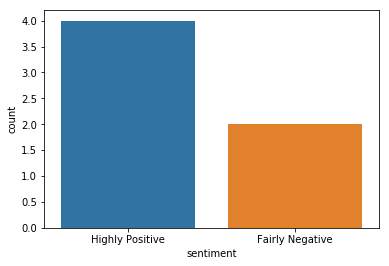

In [9]:
sns.countplot(x='sentiment', data=sample);